##### Figure 4: nucleotide diversity and Tajima's D in the Vgsc region

In [1]:
from collections import defaultdict
import dask.array as da
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import re

import allel

import ingenos

In [2]:
base_path = "/overflow/dschridelab/users/rrlove/aedes/"
md_path = f"{base_path}metadata/"
results_path = f"{base_path}results/"
zarr_path = "/proj/dschridelab/rrlove/aedes/vcf/filtered_110122/"

In [3]:
chroms = ["AaegL5_1", "AaegL5_2", "AaegL5_3"]
countries = ["Brazil", "Colombia", "USA", "Kenya", "Senegal", "Gabon"]

##### read in the data and metadata

In [4]:
def return_data(zarr_path, data_type, data_name):
    
    fetch_str = f"{data_type}/{data_name}" 
    
    return da.from_zarr(zarr_path, component=fetch_str)

In [5]:
chroms_dict = defaultdict(dict)

chroms = ["AaegL5_3"]

for chrom in chroms:
    
    temp_in_path = zarr_path + chrom

    chroms_dict[chrom]["pos"] = return_data(temp_in_path, "variants", "POS")
    chroms_dict[chrom]["chrom"] = return_data(temp_in_path, "variants", "CHROM")
    chroms_dict[chrom]["ref"] = return_data(temp_in_path, "variants", "REF")
    chroms_dict[chrom]["alt"] = return_data(temp_in_path, "variants", "ALT")
    chroms_dict[chrom]["ac"] = return_data(temp_in_path, "variants", "AC")
    chroms_dict[chrom]["qd"] = return_data(temp_in_path, "variants", "QD")
    chroms_dict[chrom]["mq"] = return_data(temp_in_path, "variants", "MQ")
    chroms_dict[chrom]["fs"] = return_data(temp_in_path, "variants", "FS")
    chroms_dict[chrom]["mqrs"] = return_data(temp_in_path, "variants", "MQRankSum")
    chroms_dict[chrom]["rprs"] = return_data(temp_in_path, "variants", "ReadPosRankSum")
    chroms_dict[chrom]["sor"] = return_data(temp_in_path, "variants", "SOR")
    chroms_dict[chrom]["is_snp"] = return_data(temp_in_path, "variants", "is_snp")
    chroms_dict[chrom]["numalt"] = return_data(temp_in_path, "variants", "numalt")
    chroms_dict[chrom]["filter_pass"] = return_data(temp_in_path, "variants", "FILTER_PASS")

    chroms_dict[chrom]["gt"] = return_data(temp_in_path, "calldata", "GT")
    chroms_dict[chrom]["gq"] = return_data(temp_in_path, "calldata", "GQ")
    chroms_dict[chrom]["ad"] = return_data(temp_in_path, "calldata", "AD")
    chroms_dict[chrom]["pl"] = return_data(temp_in_path, "calldata", "PL")
    chroms_dict[chrom]["dp"] = return_data(temp_in_path, "calldata", "DP")
    
    print(chrom, chroms_dict[chrom]["gt"].shape)
    
samples = da.from_zarr(temp_in_path, component="samples")

AaegL5_3 (27660249, 131, 2)


##### read in the metadata

In [6]:
md = pd.read_table(
    md_path + "whole_sample_sorted_country.031522.csv", 
    sep="\t",)

md["locality"] = md["location"].str.split(": ", expand=True)[1]

md.head()

,sample_id,sample_short,location,sex,batch,sample_id_cat,country,locality
0,FEMALE_1-F1_CGCATGAT-TCAGGCTT_S1,FEMALE_1,Colombia: Rio Claro,F,1,FEMALE_1-F1_CGCATGAT-TCAGGCTT_S1,Colombia,Rio Claro
1,FEMALE_10-F10_GTGCCATA-ACTAGGAG_S2,FEMALE_10,Colombia: Rio Claro,F,1,FEMALE_10-F10_GTGCCATA-ACTAGGAG_S2,Colombia,Rio Claro
2,FEMALE_11-F11_CGTTGCAA-CGCTCTAT_S3,FEMALE_11,Colombia: Rio Claro,F,1,FEMALE_11-F11_CGTTGCAA-CGCTCTAT_S3,Colombia,Rio Claro
3,FEMALE_12-F12_TGAAGACG-TGGCATGT_S4,FEMALE_12,Colombia: Rio Claro,F,1,FEMALE_12-F12_TGAAGACG-TGGCATGT_S4,Colombia,Rio Claro
4,FEMALE_14-F14_ACGTTCAG-GCACAACT_S6,FEMALE_14,Colombia: Rio Claro,F,1,FEMALE_14-F14_ACGTTCAG-GCACAACT_S6,Colombia,Rio Claro


##### remove closely-related specimens

In [7]:
to_drop = np.loadtxt(md_path + "close_kin_removed_new_dataset.txt", 
                     dtype="str")

to_drop

array(['SRR11006849', 'SRR11006846', 'SRR6768018', 'FEMALE_17',
       'FEMALE_22', 'SRR11006674', 'SRR11006683', 'SRR11006754'],
      dtype='<U11')

In [8]:
to_drop_bool = (~(md["sample_short"].isin(to_drop)).values)

np.sum(to_drop_bool)

123

In [9]:
md_filtered = md.loc[to_drop_bool]

md_filtered.shape

(123, 8)

##### read in the mask of repetitive and poorly mapping regions

In [10]:
mask = pd.read_table(
    "/overflow/dschridelab/users/rrlove/aedes/refs/aegy/unified_mask/merged_rep_map_masks.110822.bed",
sep="\t", names=["chrom", "start", "end"])

mask.head()

,chrom,start,end
0,AaegL5_1,0,273
1,AaegL5_1,297,373
2,AaegL5_1,413,7449
3,AaegL5_1,7452,8789
4,AaegL5_1,9854,18833


##### narrow to chrom 3

In [11]:
mask = mask.loc[mask["chrom"] == "AaegL5_3"]

mask.head()

,chrom,start,end
1066822,AaegL5_3,42,150
1066823,AaegL5_3,165,486
1066824,AaegL5_3,500,527
1066825,AaegL5_3,617,618
1066826,AaegL5_3,636,650


##### read in genes

In [12]:
gff3 = pd.read_table("/overflow/dschridelab/users/rrlove/aedes/refs/aegy/VectorBase-54_AaegyptiLVP_AGWG.gff",
                     sep="\t", comment="#", header=None)

gff3.columns = ["seqid", "source", "type", "start", "end", "score", "strand",
               "phase", "attributes"]

gff3["name"] = gff3["attributes"].str.split(";", expand=True)[0].str.lstrip("ID=")

genes = gff3.loc[gff3["type"] == "protein_coding_gene"]

genes.head()

,seqid,source,type,start,end,score,strand,phase,attributes,name
0,AaegL5_3,VEuPathDB,protein_coding_gene,157422094,157471671,.,-,.,ID=AAEL010223;description=phosphatidylserine d...,AAEL010223
67,AaegL5_2,VEuPathDB,protein_coding_gene,65150768,65155203,.,-,.,ID=AAEL013940;description=chromatin assembly f...,AAEL013940
79,AaegL5_2,VEuPathDB,protein_coding_gene,303181186,303183527,.,+,.,ID=AAEL002384;description=unspecified product,AAEL002384
89,AaegL5_1,VEuPathDB,protein_coding_gene,247947181,247966533,.,-,.,ID=AAEL003769;description=Methionine aminopept...,AAEL003769
105,AaegL5_3,VEuPathDB,protein_coding_gene,368609784,368611605,.,+,.,ID=AAEL014609;Name=CYP9J26;description=cytochr...,AAEL014609


In [13]:
genes_1 = genes.loc[genes["seqid"] == "AaegL5_1"]
genes_2 = genes.loc[genes["seqid"] == "AaegL5_2"]
genes_3 = genes.loc[genes["seqid"] == "AaegL5_3"]

##### set up filtering by country

In [14]:
country_bools = {}

for country in countries:
    
    country_bools[country] = (md_filtered["country"] == country).values
    
country_bools.keys()

dict_keys(['Brazil', 'Colombia', 'USA', 'Kenya', 'Senegal', 'Gabon'])

In [15]:
region_flt = ((chroms_dict[chrom]["pos"] > 310000000) & \
            (chroms_dict[chrom]["pos"] < 320000000))

np.sum(region_flt).compute()

641298

In [16]:
vgsc_flt = ((chroms_dict[chrom]["pos"] > 315926360) &\
            (chroms_dict[chrom]["pos"] < 316405639))

np.sum(vgsc_flt.compute())

33298

In [17]:
vgsc_gt = allel.GenotypeArray(chroms_dict[chrom]["gt"]).subset(sel0 = region_flt, 
                                                          sel1 = to_drop_bool)

vgsc_gt.shape

(641298, 123, 2)

In [18]:
vgsc_gq = chroms_dict[chrom]["gq"][region_flt, :][:, to_drop_bool].compute()

vgsc_gq.shape

(641298, 123)

In [19]:
pos = chroms_dict[chrom]["pos"][region_flt].compute()

pos.shape

(641298,)

##### Calculate pi and Tajima's D

In [20]:
vgsc_overlapping_by_country = defaultdict(dict)

for country, country_flt in country_bools.items():

    country_gt = vgsc_gt.subset(sel1 = country_flt)
    
    ##all sites, all genotypes

    pi, windows, n_bases, counts = allel.windowed_diversity(pos, 
                                                            country_gt.count_alleles(), 
                                                            size=500000, 
                                                            step=50000)

    vgsc_overlapping_by_country["pi"][country] = \
    (pi, windows, n_bases, counts)

    d, windows, counts = allel.windowed_tajima_d(pos, 
                                                 country_gt.count_alleles(), 
                                                 size=500000,
                                                 step=50000)

    vgsc_overlapping_by_country["d"][country] = \
    (d, windows, counts)

    print(country)

Brazil
Colombia
USA
Kenya
Senegal
Gabon


##### plot

In [21]:
#from https://stackoverflow.com/questions/27575257/how-to-divide-y-ticks-by-a-certain-number-in-matplotlib

def numfmt(x, pos):
    s = '{}'.format((x / 1000000))
    return s

yfmt = tkr.FuncFormatter(numfmt)

In [22]:
outString = ingenos.make_date_stamp(
    results_path + "Vssc/Vgsc_pi_D_along_chrom_all_sites_genotypes_with_labels", ".pdf")

outString

'/overflow/dschridelab/users/rrlove/aedes/results/Vssc/Vgsc_pi_D_along_chrom_all_sites_genotypes_with_labels.021023.pdf'

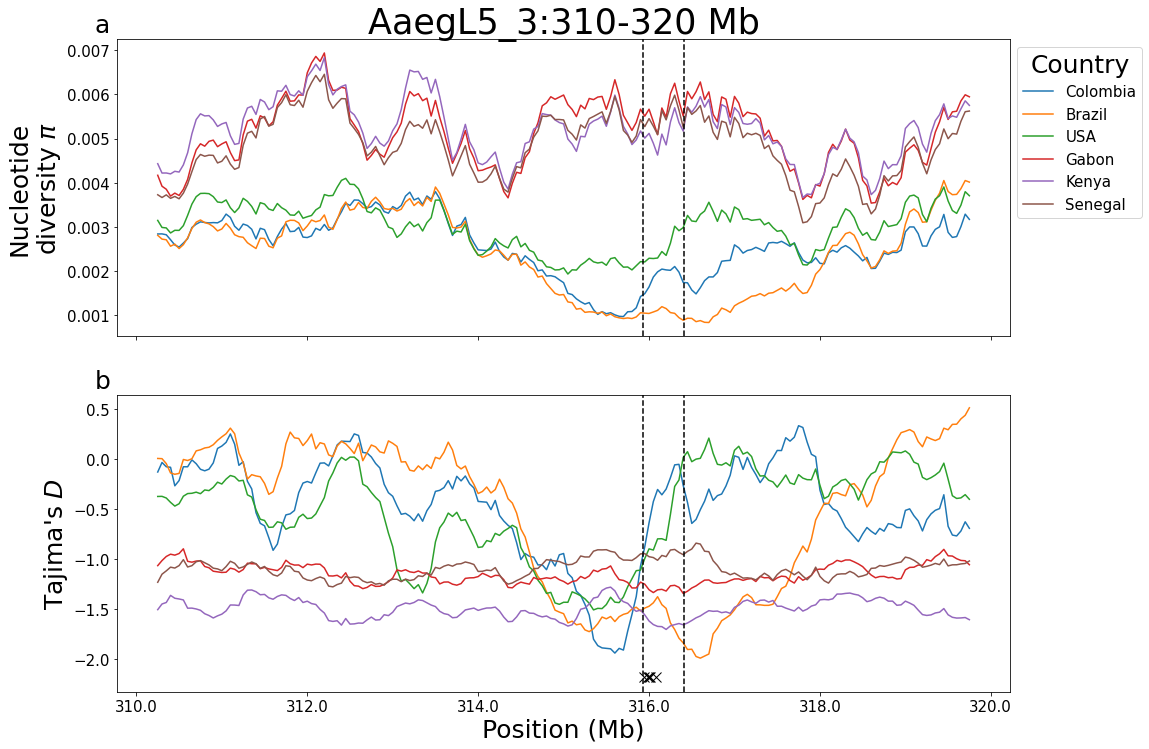

In [23]:
fig, axes = plt.subplots(nrows=2, figsize=(16, 12), sharex="col")

for country in ["Colombia", "Brazil", "USA", "Gabon", "Kenya", "Senegal"]:

    pi, pi_windows, n_bases, pi_counts = \
    vgsc_overlapping_by_country["pi"][country]

    d, d_windows, d_counts = \
    vgsc_overlapping_by_country["d"][country]
    
    axes[0].plot(np.mean(pi_windows, axis=1), pi, label=country)

    axes[1].plot(np.mean(d_windows, axis=1), d, label=country)

trans = transforms.blended_transform_factory(
    axes[1].transData, axes[1].transAxes)

for snp in [315939224, 315983763, 315999297, 316014588, 316080722]:

    axes[1].plot(snp, 0.05, marker="x", markersize=10, color="black", 
                 transform=trans, linestyle=" ")

lower_bound = axes[1].get_ylim()[0]
axes[1].set_ylim(bottom=lower_bound*1.1)

for ax in axes:
    ax.axvline(x = 315926360, linestyle = "--", color = "black")
    ax.axvline(x = 316405639, linestyle = "--", color = "black")

axes[0].set_title("AaegL5_3:310-320 Mb", fontsize=35)
axes[0].legend(title="Country", fontsize=15, title_fontsize=25,
                   bbox_to_anchor=(1.0, 1))
axes[0].set_ylabel("Nucleotide\n" + r"diversity $\pi$", fontsize=25)

axes[1].set_xlabel("Position (Mb)", size=25)
axes[1].xaxis.set_major_formatter(yfmt)
axes[1].set_ylabel(r"Tajima's $D$", fontsize=25)

for ax in axes:
    ax.tick_params(axis="both", labelsize=15)

for i, ax in enumerate(axes):
    label = ["a","b"][i]
    ax.text(x=-0.025, y=1.025, s=label, 
            transform=ax.transAxes, fontsize=25)
    
#plt.tight_layout()
    
#plt.savefig(outString, bbox_inches="tight")

##### Figure S15: plot Tajima's D and nucleotide diversity in the same region, focusing on South American specimens in the top or bottom clusters of the Vgsc PCA

##### plot the PCA

In [24]:
vgsc_gt = allel.GenotypeArray(chroms_dict[chrom]["gt"]).subset(
    sel0 = vgsc_flt.compute(), sel1 = to_drop_bool)

vgsc_gt.shape

(33298, 123, 2)

In [25]:
pos = chroms_dict[chrom]["pos"][vgsc_flt].compute()

pos.shape

(33298,)

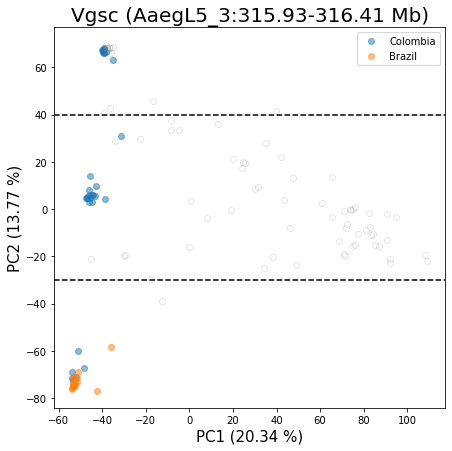

In [26]:
pos = chroms_dict["AaegL5_3"]["pos"]

fig, ax = plt.subplots(figsize=(7, 7))

##calculate and plot PCA
allele_counts = allel.AlleleCountsArray(vgsc_gt.count_alleles())
    
allele_counts_boolean = (allele_counts.max_allele() <= 2) &\
(allele_counts[:, :2].min(axis=1) > 1) & (
    allele_counts.to_frequencies()[:,1] > 0.05)
                         
n_alts = vgsc_gt.subset(sel0 = allele_counts_boolean).to_n_alt()
    
coords, model = allel.pca(n_alts)

x = coords[:, 0]
y = coords[:, 1]

for country in ["Colombia", "Brazil", "USA", "Gabon", "Kenya", "Senegal"]:
    
    flt = md_filtered["country"] == country
    
    if country != "Colombia" and country != "Brazil":
    
        ax.plot(x[flt], y[flt], linestyle = ' ', marker = "o", color = "grey",
                   markerfacecolor = "None", alpha = 0.2)
        
    else:
        
        ax.plot(x[flt], y[flt], linestyle = ' ', marker = "o", label = country,
                   alpha = 0.5)
        
##show boundaries chosen for dividing between clusters

ax.axhline(y=40, color = "black", linestyle = "--")
ax.axhline(y=-30, color = "black", linestyle = "--")

ax.set_xlabel(f"PC1 ({round(model.explained_variance_ratio_[0]*100, 2)} %)", 
               fontsize=15)
ax.set_ylabel(f"PC2 ({round(model.explained_variance_ratio_[1]*100, 2)} %)", 
               fontsize=15)

ax.set_title("Vgsc (AaegL5_3:315.93-316.41 Mb)", fontsize=20)

ax.legend()

In [27]:
sa_flt = md_filtered["country"].isin(["Brazil", "Colombia"])

print(np.sum(sa_flt))

48


In [28]:
top_cluster = (y[sa_flt] > 40)

middle_cluster = ((y[sa_flt] <= 40) & (y[sa_flt] > -30))

bottom_cluster = (y[sa_flt] < -30)

print(np.sum(top_cluster), np.sum(middle_cluster), np.sum(bottom_cluster))

10 16 22


In [29]:
region_gt = \
allel.GenotypeArray(chroms_dict[chrom]["gt"]).subset(sel0 = region_flt, 
                                                     sel1 = to_drop_bool)

region_gt.shape

(641298, 123, 2)

In [30]:
pi_dict = {}

pi_dict["Brazil"] = \
allel.windowed_diversity(chroms_dict[chrom]["pos"][region_flt], 
                         region_gt.subset(sel1 = country_bools["Brazil"]).count_alleles(), 
                         size=500000, step=50000)

pi_dict["Colombia"] = \
allel.windowed_diversity(chroms_dict[chrom]["pos"][region_flt], 
                         region_gt.subset(sel1 = country_bools["Colombia"]).count_alleles(), 
                         size=500000, step=50000)

pi_dict["top"] = \
allel.windowed_diversity(chroms_dict[chrom]["pos"][region_flt], 
                         region_gt.subset(sel1 = sa_flt).subset(sel1 = top_cluster).count_alleles(), 
                         size=500000, step=50000)

pi_dict["middle"] = \
allel.windowed_diversity(chroms_dict[chrom]["pos"][region_flt], 
                         region_gt.subset(sel1 = sa_flt).subset(sel1 = middle_cluster).count_alleles(), 
                         size=500000, step=50000)

pi_dict["bottom"] = \
allel.windowed_diversity(chroms_dict[chrom]["pos"][region_flt], 
                         region_gt.subset(sel1 = sa_flt).subset(sel1 = bottom_cluster).count_alleles(), 
                         size=500000, step=50000)



In [31]:
outString = ingenos.make_date_stamp(
    results_path + "Vssc/Vgsc_pi_by_PCA_stripe_new_dataset", ".pdf")

outString

'/overflow/dschridelab/users/rrlove/aedes/results/Vssc/Vgsc_pi_by_PCA_stripe_new_dataset.021023.pdf'

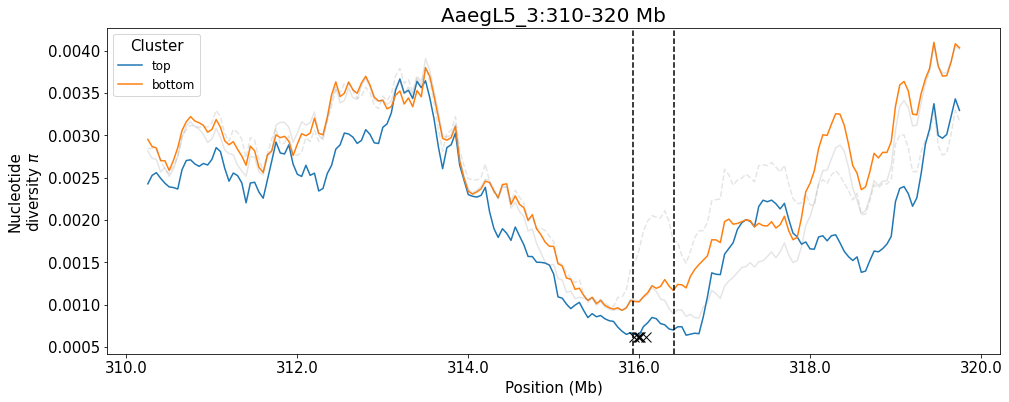

In [32]:
fig, ax = plt.subplots(figsize=(16, 6))

for label in ["top", "bottom", "Brazil", "Colombia"]:
    
    out, windows, _, _ = pi_dict[label]
    
    if label == "Brazil":
    
        ax.plot(np.mean(windows, axis=1), out, color = "grey", alpha = 0.2)
        
    elif label == "Colombia":
        
        ax.plot(np.mean(windows, axis=1), out, color = "grey", linestyle = "--",
                alpha = 0.2)
        
    else:
        
        ax.plot(np.mean(windows, axis=1), out, label = label)
    
trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)

for snp in [315939224, 315983763, 315999297, 316014588, 316080722]:
    
    ax.plot(snp, 0.05, marker="x", markersize=10, color="black", transform=trans, linestyle=" ")
    
lower_bound = ax.get_ylim()[0]
ax.set_ylim(bottom=lower_bound*.9)
    
ax.legend(title="Cluster", fontsize=12, title_fontsize=15)

ax.axvline(x = 315926360, linestyle = "--", color = "black")
ax.axvline(x = 316405639, linestyle = "--", color = "black")

ax.set_xlabel("Position (Mb)", size=15)
ax.set_ylabel("Nucleotide\n" + r"diversity $\pi$", fontsize=15)
ax.set_title("AaegL5_3:310-320 Mb", fontsize=20)

ax.xaxis.set_major_formatter(yfmt)

ax.tick_params(axis="both", labelsize=15)

#plt.savefig(outString, bbox_inches="tight")